# 評価方法

分類されていないデータを認識し、どれだけ正しくカテゴリごとに分類できるかを算出した「平均精度」の高さを競い合います。

今回、活用するデータはLSWMD_25519となります。
LSWMD_25519のFailureType項目が分類されていない状態のデータに対し、正しいFailureTypeカテゴリを分類するプログラムを作成し、その平均精度を算出します。
平均精度とは、カテゴリごとに正しく分類できる精度を平均した値です。カテゴリごとに算出した精度（Aが正しく分類された数/Aのデータ数）を足し、カテゴリ数で割ります。

公平な評価を実施するために、以下の制限を設けています。
1. 外部パッケージをインストールするためのセルとsolution関数の中身のみを編集すること
2. 校舎のiMac上で最後のセルの実行時間が15分未満であること　（%%timeitの出力結果を確認してください）

※気になる点がある場合、Discordで気軽にお問合せください。

In [1]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

外部パッケージを使用する場合、以下の方法でインストールを実施してください。

In [2]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
# !pip install keras
# !pip install tensorflow[and-cuda]
!pip install tensorflow
!pip install Pillow
!pip install matplotlib

以下のsolution関数のみ編集してください。

In [3]:
def solution_random(x_test_df, train_df):
    # こちらの関数の中身を編集してください。
    import random
    failure_types = list(train_df['failureType'].unique())
    num_rows = len(x_test_df)
    while len(failure_types) < num_rows:
        failure_types.append(random.choice(failure_types))

    return pd.DataFrame({'failureType': failure_types}, index=x_test_df.index)

In [4]:
def normalize_map(map, back_map, resize_shape = (32, 32)):
    from PIL import Image

    # マップの次元を取得
    len_y, len_x = map.shape

    # マップの中心y座標とx座標を取得
    y_add = len_y // 2 + len_y % 2
    x_add = len_x // 2 + len_x % 2

    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(map == 0)
    # 他の位置に置換
    map[y_indices, x_indices] = back_map[(y_indices + y_add) % len_y, (x_indices + x_add) % len_x]
    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(map == 0)
    # 0の値を置換
    map[y_indices, x_indices] = 1

    # リサイズし1を減算
    map = Image.fromarray(map - 1.0)
    # mapから1を減算してPILイメージを作成
    resized_map = map.resize(resize_shape, Image.LANCZOS)

    return np.asarray(resized_map)

def create_back_map(map, index):
    if index == 0:
        return map
    elif index == 1:
        return np.rot90(map, k=2)
    elif index == 2:
        return np.flip(map, axis=1)
    elif index == 3:
        return np.rot90(np.flip(map, axis=1), k=2)

def preprocess_map2(train_df, normalize_map):
    # データの正規化
    train_maps = np.array([normalize_map(x.copy(), create_back_map(x, i)) for i in range(4) for x in train_df['waferMap']])

    # 1. 画像を水平方向に反転
    flipped_horizontally = np.flip(train_maps, axis=2)
    train_maps = np.concatenate((train_maps, flipped_horizontally), axis=0)

    # 2. 画像を180度回転
    rotated_180 = np.rot90(train_maps, k=2, axes=(1, 2))
    train_maps = np.concatenate((train_maps, rotated_180), axis=0)

    # 3. 画像を90度回転
    rotated_90 = np.rot90(train_maps, k=1, axes=(1, 2))
    train_maps = np.concatenate((train_maps, rotated_90), axis=0)

    # データの形状を変更
    train_maps = train_maps.reshape(train_maps.shape + (1,))

    return train_maps


def create_model(input_shape, num_classes):
    import tensorflow as tf

    model = tf.keras.models.Sequential([
        # 畳み込みブロック1
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same', input_shape=(input_shape)),
        tf.keras.layers.MaxPooling2D(pool_size=2, padding='same'),
        
        # 畳み込みブロック2
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        
        # 畳み込みブロック3
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        
        # ブロック4
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(16, activation=tf.nn.relu),

        # 出力層
        tf.keras.layers.Dense(num_classes),
    ])

    return model


def calculate_class_weights(train_labels):
    from sklearn.utils.class_weight import compute_class_weight
    # クラスの重みを計算
    class_weights = compute_class_weight(class_weight='balanced', 
                                         classes=np.unique(train_labels), 
                                         y=train_labels)
    # クラスの重みを辞書型に変換
    return dict(enumerate(class_weights))


def show_img(image):
    import matplotlib.pyplot as plt

    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [5]:
def solution(x_test_df, train_df):
    import tensorflow as tf
    failure_types = list(train_df['failureType'].unique())

    # 前処理
    # test_maps = preprocess_map1(x_test_df, normalize_map)
    test_maps = preprocess_map2(x_test_df, normalize_map)
    train_maps = preprocess_map2(train_df, normalize_map)
    train_labels = np.array([failure_types.index(x) for x in train_df['failureType']] * 32)

    print(train_labels)
    show_img(train_maps[0])
    show_img(train_maps[len(train_df['waferMap']) * 8])
    show_img(train_maps[len(train_df['waferMap']) * 8 * 2])
    show_img(train_maps[len(train_df['waferMap']) * 8 * 3])
    show_img(train_maps[1])
    
    
    # クラスの重みを計算
    class_weights = calculate_class_weights(train_labels)

    # モデルの作成
    model = create_model(train_maps[0].shape, len(failure_types))
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.fit(train_maps, train_labels, epochs=3, class_weight=class_weights)

    test_len = len(x_test_df['waferMap'])
    # 予測
    logits = model.predict(test_maps)
    test_logits = np.zeros(test_len * len(failure_types), dtype=np.float64).reshape((test_len,len(failure_types)))
    for n in range(32):
        test_logits += logits[test_len * n : test_len *(n + 1)]
    
    predictions = tf.nn.softmax(test_logits).numpy()
    answer = [failure_types[x.argmax()] for x in predictions]

    return pd.DataFrame({'failureType': answer}, index=x_test_df.index)


solution関数は以下のように活用され、平均精度を計算します。

[0 1 2 ... 1 3 2]


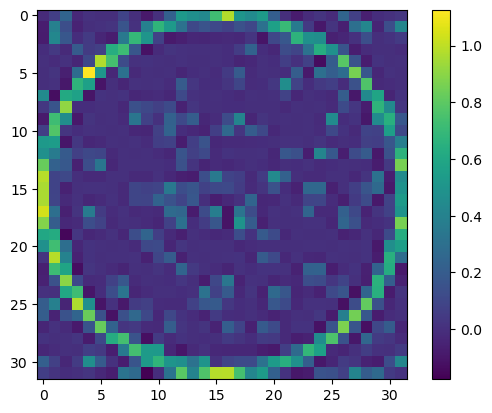

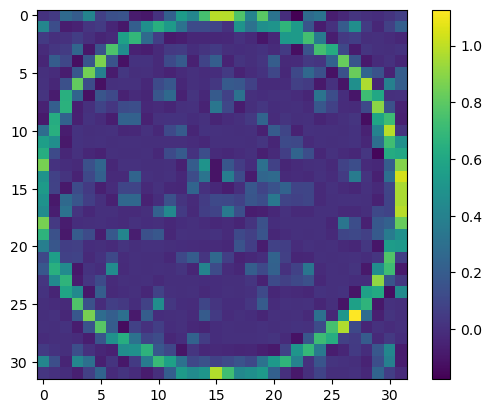

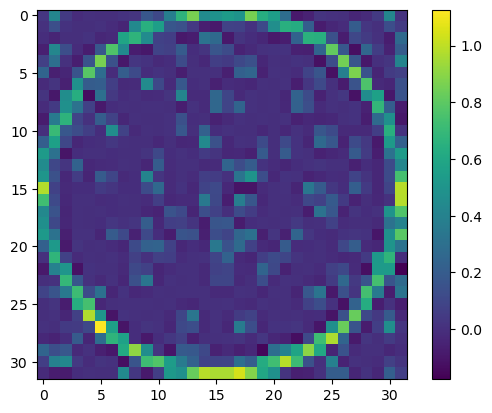

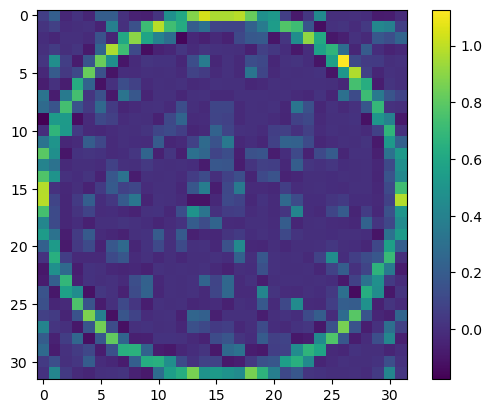

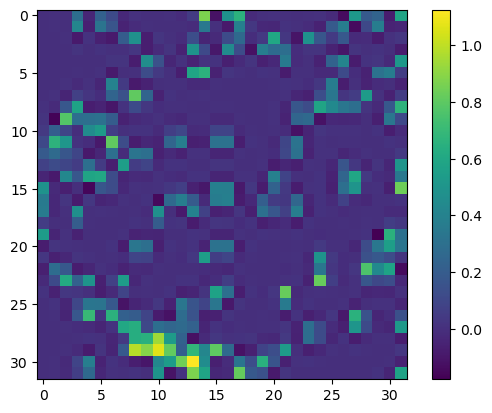

2023-11-21 02:21:28.961403: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3010330624 exceeds 10% of free system memory.


Epoch 1/3
22967/22967 [==============================] - 155s 7ms/step - loss: 0.2796 - accuracy: 0.8982
Epoch 2/3
22967/22967 [==============================] - 152s 7ms/step - loss: 0.1536 - accuracy: 0.9401
Epoch 3/3
22967/22967 [==============================] - 171s 7ms/step - loss: 0.1306 - accuracy: 0.9472


2023-11-21 02:30:35.215734: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 334495744 exceeds 10% of free system memory.


2552/2552 [==============================] - 7s 2ms/step
平均精度：94.44%


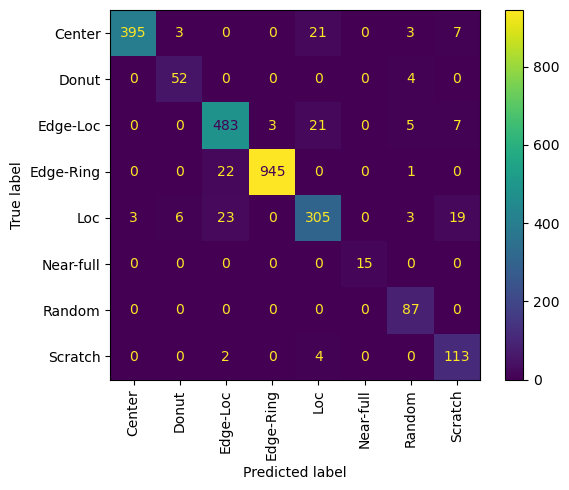

誤分類されたデータ:
                                                waferMap  dieSize   lotName  \
21506  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1421.0  lot44807   
20084  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1256.0  lot43843   
19017  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1129.0  lot42616   
24617  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2,...    562.0  lot46963   
36     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...    533.0     lot36   
...                                                  ...      ...       ...   
12118  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1080.0  lot21611   
18881  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1198.0  lot42391   
10652  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  12662.0  lot19842   
22852  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,...    904.0  lot45634   
17671  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    776.0  lot40792   

       waferIndex failureType  
21506   

In [6]:
%%timeit -r 1 -n 1

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))
    
    average_accuracy = sum(accuracies.values())/len(accuracies)

print(f"平均精度：{average_accuracy*100:.2f}%")

# Confusion Matrixを計算
cm = confusion_matrix(y_test_df, user_result_df, labels=df['failureType'].unique())

# Confusion Matrixを可視化
ConfusionMatrixDisplay.from_predictions(y_test_df, user_result_df, xticks_rotation="vertical")
plt.show()

# 誤分類されたデータの抽出
misclassified_indices = y_test_df.index[y_test_df['failureType'] != user_result_df['failureType']]
misclassified_data = test_df.loc[misclassified_indices]

# 誤分類されたデータを表示
print("誤分類されたデータ:")
print(misclassified_data)
#for map in misclassified_data['waferMap']:
#    print(map.shape)
#    show_img(map)

